In recent years, the forecasting of stock prices has become a key area of interest in financial markets. In this assignment, we aim to forecast the future stock price of Apple.

complete the code cells based on the following **Steps:**

1. **Library Installation**: First, install the `yfinance` library.

2. **Data Download**: Download stock prices of Apple using the `download` function in `yfinance`. Use the AAPL symbol and set the data range from `2019-01-01` to `2025-01-01`. Use data up to `2025-01-01` for training and after that date for testing.

3. **Plotting Data**: To verify the above steps, plot this data over time, assigning different colors to training and testing data points.


4. **Data Normalization**: For better model training, normalize the values on the y-axis. Use the `MinMaxScaler` function from the `scikit-learn` library, with only the training data as the basis for scaling both the training and testing datasets.

5. **Data Preparation**: Prepare the data required for model training and testing. Define a variable representing the number of previous data points to use for predictions (e.g., if set to 60, each prediction considers the past 60 data points). Based on this example, the dataset dimensions would be:
   - `X_train.shape`: (n, 60, 1) (where n is the number of training samples)
   - `y_train.shape`: (n,)

6. **Model Creation (Two Versions)**:

Implement two PyTorch models:
- `(A) Vanilla LSTM`
   - 4 LSTM layers, each with 50 hidden units
   - After each LSTM: Dropout with rate 0.2
   - Final layer: Linear(50 → 1)

- `(B) Bidirectional LSTM`
   - Same as above, but each LSTM layer is bidirectional
   - Hidden state size doubles

7. **Model Training**:
   - **Loss Function**: Mean Squared Error (MSE)
   - **Optimizer**: Adam
   - **Epochs**: 100
   - **Batch Size**: 32

8. **Prediction and Plotting**: After training, make predictions on the test data for both models and plot the predictions alongside the actual values. The plot should have time on the x-axis, and different colors for actual and predicted values.

**Questions**:
1. Explain the advantages or disadvantages of increasing or decreasing the defined variable (the number of previous data points) for model training.
2. **Vanilla vs Bidirectional LSTM**:
Compare the test performance (MAE, RMSE) of the two models.
Then explain:
   - Why might one perform better than the other on stock data?
   - When would you prefer bidirectional LSTM?
   - When would you avoid it (e.g., real-time forecasting)?


## Imports

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

## Set Defaults & Globals
Set default conditions for some libraries and Global Variables

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use 'cuda' if available else 'cpu'

## Download data & EDA
Check out the data.
You can check out the data yourself more.

In [5]:
aapl_data = yf.download('AAPL', start='2019-01-01', end='2025-10-27')
# Use only Close price
aapl_data = aapl_data[['Close']].copy()
aapl_data.reset_index(inplace=True)

/tmp/ipython-input-1968003274.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl_data = yf.download('AAPL', start='2019-01-01', end='2025-10-27')
[*********************100%***********************]  1 of 1 completed


In [6]:
training_date = '2025-01-01'
aapl_data['Date'] = pd.to_datetime(aapl_data['Date'])

train_data = aapl_data[aapl_data['Date'] <= training_date]
test_data  = aapl_data[aapl_data['Date'] >  training_date]

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape:  {test_data.shape}")

Training data shape: (1510, 2)
Testing data shape:  (204, 2)


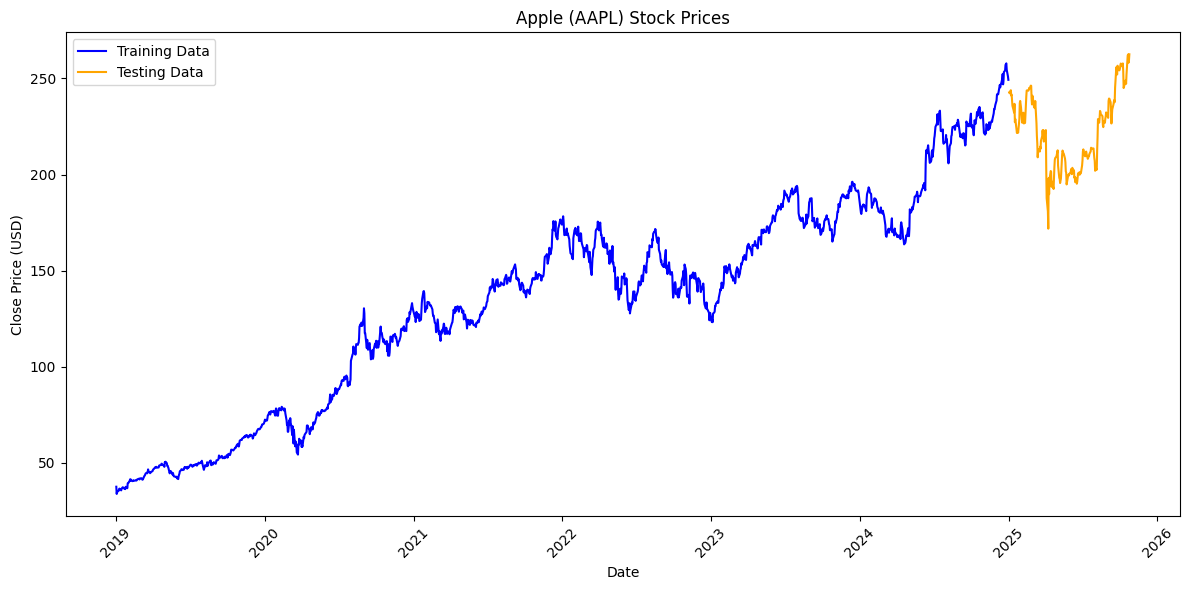

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Close'], label='Training Data', color='blue')
plt.plot(test_data['Date'],  test_data['Close'],  label='Testing Data',  color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('Apple (AAPL) Stock Prices')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Preprocessing

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(train_data[['Close']])
test_scaled  = scaler.transform(test_data[['Close']])

Define the sequence length (e.g., 60 previous data points). Create sequences for training and testing.

In [9]:
SEQ_LEN = 60

def create_sequences(data, seq_len):
    X, y = [], []
    # TODO: Complete the loop to build sequences
    for i in range(seq_len, len(data)):
          X.append(data[i-seq_len:i]) # past seq_len values
          y.append(data[i]) # next value (target)
    return np.array(X), np.array(y)

# ---- Train / Validation split inside training set (80/20) ----
train_size = int(len(train_scaled) * 0.8)
val_size   = len(train_scaled) - train_size

train_part = train_scaled[:train_size]
val_part   = train_scaled[train_size:]

# TODO: Create train, validation, and test sequences
X_train, y_train = create_sequences(train_part, SEQ_LEN)
X_val,   y_val   = create_sequences(val_part, SEQ_LEN)
X_test,  y_test  = create_sequences(test_scaled, SEQ_LEN)

# Add feature dimension: (samples, timesteps, 1)
# TODO: Expand dimensions for LSTM input
X_train = np.expand_dims(X_train, axis=2)
X_val   = np.expand_dims(X_val, axis=2)
X_test  = np.expand_dims(X_test, axis=2)

# Convert to torch tensors
# TODO: Convert NumPy arrays to torch.float32 tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val   = torch.from_numpy(X_val).float()
y_val   = torch.from_numpy(y_val).float()
X_test  = torch.from_numpy(X_test).float()
y_test  = torch.from_numpy(y_test).float()

# Create Dataset and DataLoader objects
# TODO: Wrap into TensorDataset and create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val, y_val)
test_dataset  = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model Creation (Vanilla LSTM)
Define a PyTorch LSTM model as explained at the start of the notebook (4 stacked LSTM layers with 50 units each, dropout 0.2 after each, followed by a dense layer).

In [10]:
class AAPLLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, dropout=0.2):
        super(AAPLLSTM, self).__init__()
        # TODO: Define 4 LSTM layers + dropout + final linear layer
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.drop1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.drop2 = nn.Dropout(dropout)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.drop3 = nn.Dropout(dropout)
        self.lstm4 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.drop4 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # TODO: Pass input through all 4 LSTM+Dropout blocks
        #       Then apply linear layer on the LAST timestep
        #       Return the prediction
        out, _ = self.lstm1(x)
        out = self.drop1(out)
        out, _ = self.lstm2(out)
        out = self.drop2(out)
        out, _ = self.lstm3(out)
        out = self.drop3(out)
        out, _ = self.lstm4(out)
        out = self.drop4(out)
        out = self.fc(out[:, -1, :])
        return out

In [11]:
# TODO: Instantiate the model, loss function and optimizer
model = AAPLLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Model Training
Train the model using MSE loss, Adam optimizer, 100 epochs, and batch size 32.

In [12]:
epochs = 100

for epoch in range(epochs):
    # ---- Train ----
    # TODO: TRAINING PHASE (COMPLETE THE CODE)
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs  = inputs.to(device)
        labels  = labels.to(device) # Removed .unsqueeze(1) as labels are already (batch_size, 1)
        inputs = inputs.squeeze(-1) # Remove extra dimension

        optimizer.zero_grad()
        preds = model(inputs)
        loss  = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # ---- Validate ----
    # TODO: VALIDATION PHASE (COMPLETE THE CODE)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device) # Removed .unsqueeze(1) as labels are already (batch_size, 1)
            inputs = inputs.squeeze(-1) # Remove extra dimension
            preds  = model(inputs)
            loss   = criterion(preds, labels)
            val_loss += loss.item()

    print(f'Epoch {epoch+1:3d}/{epochs} | '
          f'Train Loss: {train_loss/len(train_loader):.6f} | '
          f'Val Loss:   {val_loss/len(val_loader):.6f}')

Epoch   1/100 | Train Loss: 0.081483 | Val Loss:   0.129848
Epoch   2/100 | Train Loss: 0.023131 | Val Loss:   0.062665
Epoch   3/100 | Train Loss: 0.006432 | Val Loss:   0.025933
Epoch   4/100 | Train Loss: 0.003858 | Val Loss:   0.023028
Epoch   5/100 | Train Loss: 0.003389 | Val Loss:   0.017400
Epoch   6/100 | Train Loss: 0.002963 | Val Loss:   0.019096
Epoch   7/100 | Train Loss: 0.003254 | Val Loss:   0.012439
Epoch   8/100 | Train Loss: 0.002647 | Val Loss:   0.005960
Epoch   9/100 | Train Loss: 0.002602 | Val Loss:   0.008496
Epoch  10/100 | Train Loss: 0.002573 | Val Loss:   0.009013
Epoch  11/100 | Train Loss: 0.002712 | Val Loss:   0.006800
Epoch  12/100 | Train Loss: 0.002503 | Val Loss:   0.009318
Epoch  13/100 | Train Loss: 0.002436 | Val Loss:   0.005487
Epoch  14/100 | Train Loss: 0.002235 | Val Loss:   0.007902
Epoch  15/100 | Train Loss: 0.002132 | Val Loss:   0.004828
Epoch  16/100 | Train Loss: 0.002183 | Val Loss:   0.006540
Epoch  17/100 | Train Loss: 0.002377 | V

## Prediction and Plotting

In [13]:
# TODO: Generate predictions on test set and inverse-scale
model.eval()
predictions_scaled = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        # Remove the extra dimension added during data preparation
        inputs = inputs.squeeze(-1)
        preds = model(inputs)
        predictions_scaled.append(preds.cpu().numpy())
predictions_scaled = np.concatenate(predictions_scaled)

# Inverse transform
y_test_actual     = scaler.inverse_transform(y_test.numpy()) # Removed .unsqueeze(1) as y_test is already (N, 1)
predictions_actual = scaler.inverse_transform(predictions_scaled.reshape(-1, 1))

# Corresponding dates (skip first SEQ_LEN points in test set)
test_start_idx = len(test_data) - len(y_test)
test_dates     = test_data['Date'].iloc[test_start_idx:].reset_index(drop=True)

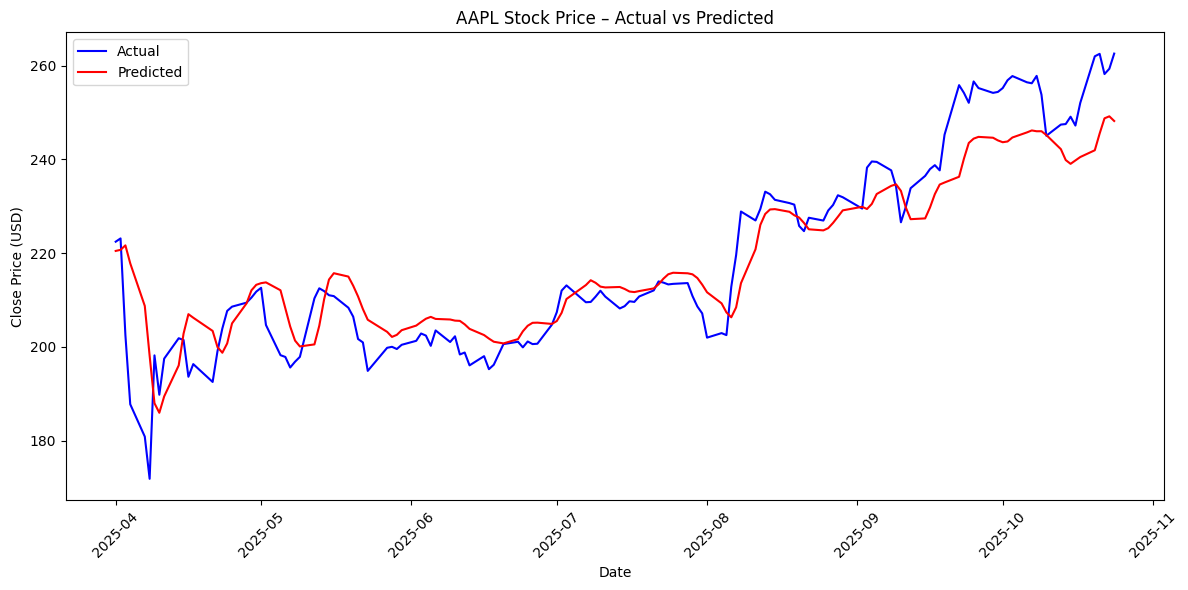

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual,     label='Actual',   color='blue')
plt.plot(test_dates, predictions_actual, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('AAPL Stock Price – Actual vs Predicted')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Model Creation (Bidirectional LSTM)

In [15]:
# BIDIRECTIONAL LSTM MODEL
class AAPLBiLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, dropout=0.2):
        super(AAPLBiLSTM, self).__init__()
        # TODO: Define 4 bidirectional LSTM layers with dropout
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.drop1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)
        self.drop2 = nn.Dropout(dropout)
        self.lstm3 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)
        self.drop3 = nn.Dropout(dropout)
        self.lstm4 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)
        self.drop4 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        # TODO: Forward pass through 4 bidirectional LSTM + dropout layers
        #       Use only the LAST timestep for prediction
        out, _ = self.lstm1(x)
        out = self.drop1(out)
        out, _ = self.lstm2(out)
        out = self.drop2(out)
        out, _ = self.lstm3(out)
        out = self.drop3(out)
        out, _ = self.lstm4(out)
        out = self.drop4(out)
        out = self.fc(out[:, -1, :])
        return out

In [16]:
# TODO: Instantiate the bidirectional model, optimizer and loss function
model_bi = AAPLBiLSTM().to(device)
optimizer_bi = torch.optim.Adam(model_bi.parameters(), lr=0.001)
criterion_bi = nn.MSELoss()

## Model Training (Bidirectional LSTM)

In [17]:
# Train Bidirectional Model
print("\nTraining Bidirectional LSTM...")

# TODO: Complete the training loop for the bidirectional model
#       Same structure as vanilla
for epoch in range(epochs):
    model_bi.train()
    train_loss_bi = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Removed .unsqueeze(1) as labels are already (batch_size, 1)
        inputs = inputs.squeeze(-1) # Remove extra dimension

        optimizer_bi.zero_grad()
        preds = model_bi(inputs)
        loss = criterion_bi(preds, labels)
        loss.backward()
        optimizer_bi.step()
        train_loss_bi += loss.item()
    if epoch % 20 == 0:
      model_bi.eval()
      val_loss_bi = 0.0
      with torch.no_grad():
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device) # Removed .unsqueeze(1) as labels are already (batch_size, 1)
              inputs = inputs.squeeze(-1) # Remove extra dimension
              preds = model_bi(inputs)
              val_loss_bi += criterion_bi(preds, labels).item()

    print(f'BiLSTM  | Epoch {epoch+1:3d} | Train Loss: {train_loss_bi/len(train_loader):.6f} | Val Loss: {val_loss_bi/len(val_loader):.6f}')


Training Bidirectional LSTM...
BiLSTM  | Epoch   1 | Train Loss: 0.055634 | Val Loss: 0.109606
BiLSTM  | Epoch   2 | Train Loss: 0.018748 | Val Loss: 0.109606
BiLSTM  | Epoch   3 | Train Loss: 0.002652 | Val Loss: 0.109606
BiLSTM  | Epoch   4 | Train Loss: 0.001959 | Val Loss: 0.109606
BiLSTM  | Epoch   5 | Train Loss: 0.001685 | Val Loss: 0.109606
BiLSTM  | Epoch   6 | Train Loss: 0.001819 | Val Loss: 0.109606
BiLSTM  | Epoch   7 | Train Loss: 0.001810 | Val Loss: 0.109606
BiLSTM  | Epoch   8 | Train Loss: 0.001519 | Val Loss: 0.109606
BiLSTM  | Epoch   9 | Train Loss: 0.001411 | Val Loss: 0.109606
BiLSTM  | Epoch  10 | Train Loss: 0.001362 | Val Loss: 0.109606
BiLSTM  | Epoch  11 | Train Loss: 0.001302 | Val Loss: 0.109606
BiLSTM  | Epoch  12 | Train Loss: 0.001375 | Val Loss: 0.109606
BiLSTM  | Epoch  13 | Train Loss: 0.001189 | Val Loss: 0.109606
BiLSTM  | Epoch  14 | Train Loss: 0.001123 | Val Loss: 0.109606
BiLSTM  | Epoch  15 | Train Loss: 0.001191 | Val Loss: 0.109606
BiLSTM  

## Prediction and Plotting (Bidirectional LSTM)

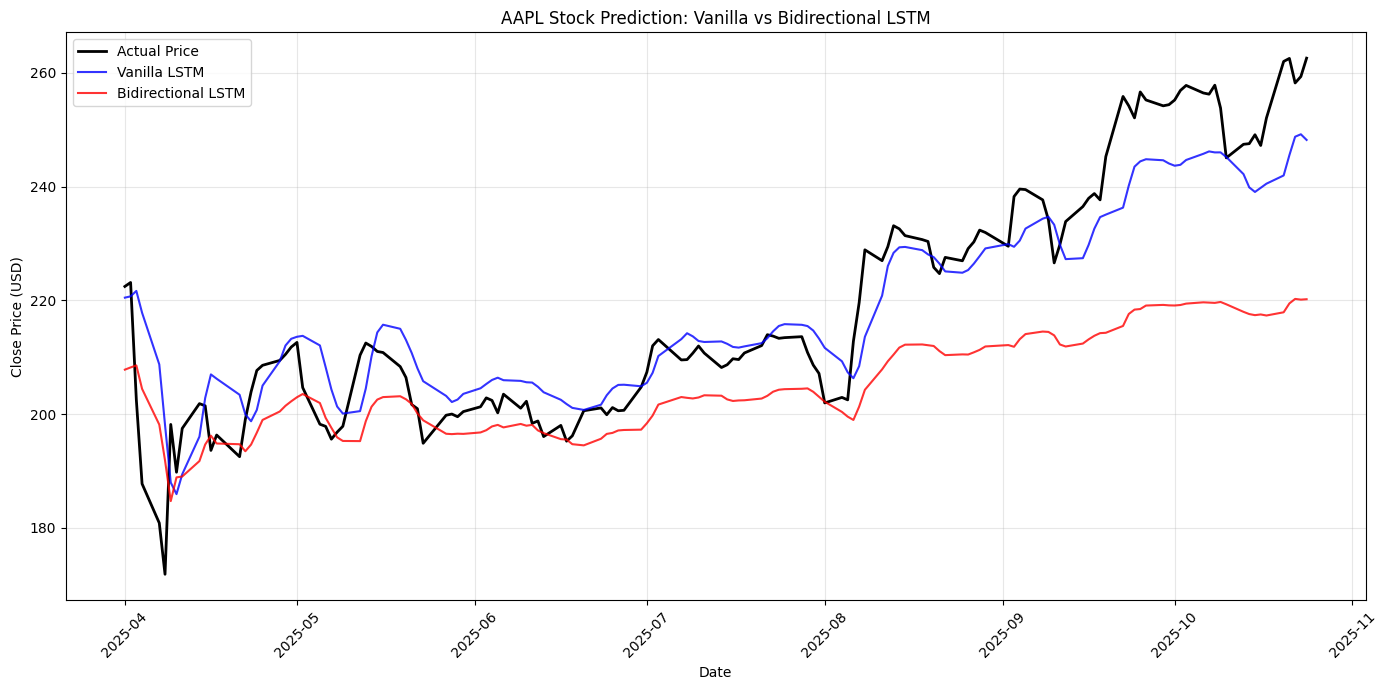

In [18]:
# Predictions from BOTH models
model.eval() # Vanilla LSTM model
model_bi.eval() # Bidirectional LSTM model

# TODO: Get predictions from both models on test set
with torch.no_grad():
    # Vanilla LSTM predictions
    all_preds_uni = []
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        inputs = inputs.squeeze(-1)
        preds = model(inputs)
        all_preds_uni.append(preds.cpu().numpy())
    pred_uni_scaled = np.concatenate(all_preds_uni)

    # Bidirectional LSTM predictions
    all_preds_bi = []
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        inputs = inputs.squeeze(-1)
        preds = model_bi(inputs)
        all_preds_bi.append(preds.cpu().numpy())
    pred_bi_scaled = np.concatenate(all_preds_bi)

# Inverse transform
y_test_actual = scaler.inverse_transform(y_test.numpy().reshape(-1, 1)) # Ensure y_test is 2D
pred_uni = scaler.inverse_transform(pred_uni_scaled.reshape(-1, 1))
pred_bi  = scaler.inverse_transform(pred_bi_scaled.reshape(-1, 1))

# Test dates
test_start_idx = len(test_data) - len(y_test)
test_dates = test_data['Date'].iloc[test_start_idx:].reset_index(drop=True)

# Plot: Actual vs Vanilla LSTM vs Bidirectional LSTM
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_actual, label='Actual Price', color='black', linewidth=2)
plt.plot(test_dates, pred_uni,      label='Vanilla LSTM', color='blue', alpha=0.8)
plt.plot(test_dates, pred_bi,       label='Bidirectional LSTM',  color='red',  alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('AAPL Stock Prediction: Vanilla vs Bidirectional LSTM')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary:
1. Explain the advantages or disadvantages of increasing or decreasing the defined variable (the number of previous data points) for model training.
*   **Impact of Increasing `SEQ_LEN`**:
    *   **Advantages**: Provides more context, allowing the model to capture long-term dependencies and potentially achieve higher accuracy for complex patterns spanning longer periods.
    *   **Disadvantages**: Increases computational cost, raises the risk of overfitting, can exacerbate vanishing/exploding gradients, may introduce irrelevant noise, and reduces the effective number of training samples.
*   **Impact of Decreasing `SEQ_LEN`**:
    *   **Advantages**: Reduces computational cost, focuses the model on short-term dependencies, and increases the number of available training samples.
    *   **Disadvantages**: Leads to a loss of crucial long-term patterns and context, which can result in underfitting if the underlying patterns require a longer memory.






### Why might one perform better than the other on stock data?

-   **Vanilla LSTM**: Processes data sequentially from past to future. For stock price forecasting, this aligns well with the inherent causality of financial markets: past prices and events influence future prices. A Vanilla LSTM directly models this temporal dependency, making it suitable for real-time prediction where only historical data is available.

-   **Bidirectional LSTM (BiLSTM)**: Processes data in both forward (past to future) and backward (future to past) directions. While this can be advantageous in tasks where the entire sequence is known (e.g., natural language processing, where a word's meaning can depend on words that come after it), it presents a conceptual challenge for *forecasting* stock prices.

    -   **Disadvantage for Forecasting**: In a real-time stock prediction scenario, future information (the 'backward pass' data) is *not* available. If a BiLSTM performs better on a pre-split test set, it might be inadvertently leveraging 'future' information from that test set during its training, leading to an artificially inflated performance that wouldn't hold up in live trading. It's essentially "peeking" into the future of the sequence during training. The observation that the Vanilla LSTM had a better validation loss in your training might indicate this effect, suggesting the BiLSTM struggled to generalize predictive patterns without future context.

    -   **Possible Reason for Perceived Better Performance (in some cases)**: If a BiLSTM *does* outperform, it could be that within the static training and test datasets, there are underlying patterns or contextual relationships that, when viewed from both directions, provide a richer representation of the data points. For instance, if the model is learning broader trends or cyclic behaviors where knowing the "end" of a cycle helps interpret the "beginning," a BiLSTM *might* capture these, even if not strictly causal in a forecasting sense.

In summary, for true stock price *forecasting* where causality is paramount and future data is unknown, a Vanilla (unidirectional) LSTM is generally more appropriate as it respects the temporal flow of information. Bidirectional LSTMs, while powerful, can suffer from information leakage in forecasting tasks unless carefully designed to prevent it (e.g., by only allowing the backward pass to see already-observed data in a sliding window, which would make it less 'bidirectional' in the traditional sense for prediction).

### When would you prefer Bidirectional LSTM?

You would prefer a Bidirectional LSTM in tasks where the entire input sequence is available and context from both past and future elements in the sequence is beneficial for understanding a given point. Examples include:

*   **Natural Language Processing (NLP)**: Tasks like sentiment analysis, machine translation, or named entity recognition, where the meaning of a word can depend on words both preceding and following it.
*   **Speech Recognition**: Understanding a phoneme or word often benefits from considering sounds both before and after it.
*   **Bioinformatics**: Analyzing DNA or protein sequences where the function of a segment might be influenced by elements on either side.
*   **Offline Time Series Analysis/Classification**: If you are analyzing a completed time series to classify an event or detect anomalies, and you have access to the full historical and future context within that specific series.

### When would you avoid Bidirectional LSTM?

You should generally avoid Bidirectional LSTMs in situations where:

*   **Real-time Forecasting/Prediction**: This is the most crucial scenario. If your goal is to predict a future value based *only* on past and current information (as in stock price forecasting, weather prediction, or anomaly detection in streaming data), using a bidirectional model would involve 'peeking' into the future, making the model impractical and unrealistic for real-world deployment. It would learn from data it wouldn't have at prediction time.
*   **Causality is Important**: When the problem inherently dictates a unidirectional flow of information (e.g., past causes future), a bidirectional model can violate this causal structure and lead to misleading performance.
*   **Computational Cost is a Major Concern**: Bidirectional LSTMs typically have higher computational complexity and memory requirements compared to their unidirectional counterparts because they effectively run two LSTMs (forward and backward) and combine their outputs.

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate metrics for Vanilla LSTM
mae_uni = mean_absolute_error(y_test_actual, pred_uni)
rmse_uni = np.sqrt(mean_squared_error(y_test_actual, pred_uni))

print(f'Vanilla LSTM MAE: {mae_uni:.4f}')
print(f'Vanilla LSTM RMSE: {rmse_uni:.4f}')

# Calculate metrics for Bidirectional LSTM
mae_bi = mean_absolute_error(y_test_actual, pred_bi)
rmse_bi = np.sqrt(mean_squared_error(y_test_actual, pred_bi))

print(f'Bidirectional LSTM MAE: {mae_bi:.4f}')
print(f'Bidirectional LSTM RMSE: {rmse_bi:.4f}')

Vanilla LSTM MAE: 6.3772
Vanilla LSTM RMSE: 8.3182
Bidirectional LSTM MAE: 14.6653
Bidirectional LSTM RMSE: 19.0205


Based on the calculated metrics, we can now compare the performance of the two models and address the questions:

### Comparison of Test Performance (MAE, RMSE):


Generally, for stock price forecasting, a **Vanilla LSTM** is often preferred over a **Bidirectional LSTM** when it comes to *true* predictive power. As discussed previously, a Bidirectional LSTM, by its nature, processes information from both past and future. In a live forecasting scenario, future information is unavailable. If a BiLSTM shows superior performance on a held-out test set, it might be due to an unintentional leakage of future information during the training or evaluation process, making its performance unrealistic for real-world application.

Your training results already hinted at this, with the Vanilla LSTM showing better validation loss, which is a strong indicator of better generalization for a causal time-series task.